# FAH GPU performance analysis example

**DISCLAIMER: the GPU benchmark data in this repo is experimental and not final. For now, the code and data presented here is intended as an example of parsing performance data from fah-core logs, and of the types of analysis that might be useful to automate intelligent assignment of work units to specific devices.**

Here we analyze performance data (`ns_per_day`) parsed from log files created by `fah-core` for the project `PROJ17101`. This project is intended to be a benchmark suite and contains 15 runs representative of the range of workloads run on FAH today.

In [1]:
import glob
import os
import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from fah_log_parser import ParseError, parse, science_log
from fah_log_parser.util.pandas import parse_logs_to_df

## Parsing a single `science.log` file

In [2]:
log = parse(science_log, "../data/PROJ17101/RUN0/CLONE0/results0/science.log")

In [3]:
log.fah_core_header.platform

'win32 10'

In [4]:
platform, device = log.get_active_device()

In [5]:
platform

PlatformInfo(profile='FULL_PROFILE', version='OpenCL 2.0 AMD-APP (1800.7)', name='AMD Accelerated Parallel Processing', vendor='Advanced Micro Devices, Inc.')

In [6]:
device

Device(name='Hainan', vendor='Advanced Micro Devices, Inc.', version='OpenCL 1.2 AMD-APP (1800.7)')

In [7]:
log.fah_core_log.average_perf_ns_day

34.1653

## Parsing all logs in a project

In [8]:
files = glob.glob("../data/PROJ17101/RUN*/CLONE*/results*/science.log")
len(files)

47782

In [9]:
if os.path.exists("checkpoint"):
    data = pd.read_feather("checkpoint")
else:
    data = parse_logs_to_df("../data/PROJ17101/")
    data.to_feather("checkpoint")
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27487 entries, 0 to 27486
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   run               27487 non-null  int64  
 1   clone             27487 non-null  int64  
 2   gen               27487 non-null  int64  
 3   os                27487 non-null  object 
 4   platform_name     27487 non-null  object 
 5   platform_vendor   27487 non-null  object 
 6   platform_version  27487 non-null  object 
 7   device_name       27487 non-null  object 
 8   device_vendor     27487 non-null  object 
 9   device_version    27487 non-null  object 
 10  perf_ns_per_day   27084 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 2.3+ MB


In [10]:
data

,run,clone,gen,os,platform_name,platform_vendor,platform_version,device_name,device_vendor,device_version,perf_ns_per_day
0,14,762,0,linux2 4.19.76-linuxkit,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 10.2.95,Tesla T4,NVIDIA Corporation,OpenCL 1.2 CUDA,190.53700
1,14,114,0,win32 10,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 11.0.140,GeForce RTX 2070 with Max-Q Design,NVIDIA Corporation,OpenCL 1.2 CUDA,222.69500
2,14,180,0,linux2 4.19.76-linuxkit,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 10.2.95,Tesla V100-SXM2-16GB,NVIDIA Corporation,OpenCL 1.2 CUDA,599.75700
3,14,729,0,win32 10,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 10.2.108,GeForce GTX 1080,NVIDIA Corporation,OpenCL 1.2 CUDA,191.92200
4,14,1394,0,win32 10,AMD Accelerated Parallel Processing,"Advanced Micro Devices, Inc.",OpenCL 2.1 AMD-APP (2671.3),Hainan,"Advanced Micro Devices, Inc.",OpenCL 1.2 AMD-APP (2671.3),12.20320
...,...,...,...,...,...,...,...,...,...,...,...
27482,13,466,0,linux2 4.19.76-linuxkit,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 10.2.95,Tesla V100-SXM2-16GB,NVIDIA Corporation,OpenCL 1.2 CUDA,356.61000
27483,13,1739,0,win32 10,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 9.1.84,Quadro P600,NVIDIA Corporation,OpenCL 1.2 CUDA,22.50330
27484,13,307,0,win32 10,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 11.0.208,GeForce GTX 1070,NVIDIA Corporation,OpenCL 1.2 CUDA,NaN
27485,13,816,0,win32 10,NVIDIA CUDA,NVIDIA Corporation,OpenCL 1.2 CUDA 11.0.126,GeForce GTX 1660,NVIDIA Corporation,OpenCL 1.2 CUDA,82.36930


In [11]:
df = (data
 .set_index(['run', 'clone', 'gen', 'device_name'])
 ['perf_ns_per_day']
 .groupby('device_name').filter(lambda x: len(x) > 10)
 .groupby('run').transform(lambda x: (x - x.mean()) / x.std()).rename('z_score_by_run')
 .groupby('device_name').mean()
).reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("z_score_by_run:Q", aggregate='mean'),
    y=alt.Y("device_name:N", sort='-x')
)

alt.Chart(...)

In [12]:
df = (data
 .set_index(['run', 'clone', 'gen', 'device_name'])
 ['perf_ns_per_day']
 .groupby(['run', 'device_name']).filter(lambda x: len(x) > 10)
 .groupby('device_name').filter(lambda x: len(x.groupby('run')) == 15)
 .groupby(['run', 'device_name']).mean()
 .rename('mean_ns_per_day')
).reset_index()

alt.Chart(df).mark_point(filled=True).encode(
    x=alt.X('mean_ns_per_day:Q', scale=alt.Scale(type='log')),
    y=alt.Y('device_name:O', sort='-x'),
    color='run:N',
)

alt.Chart(...)

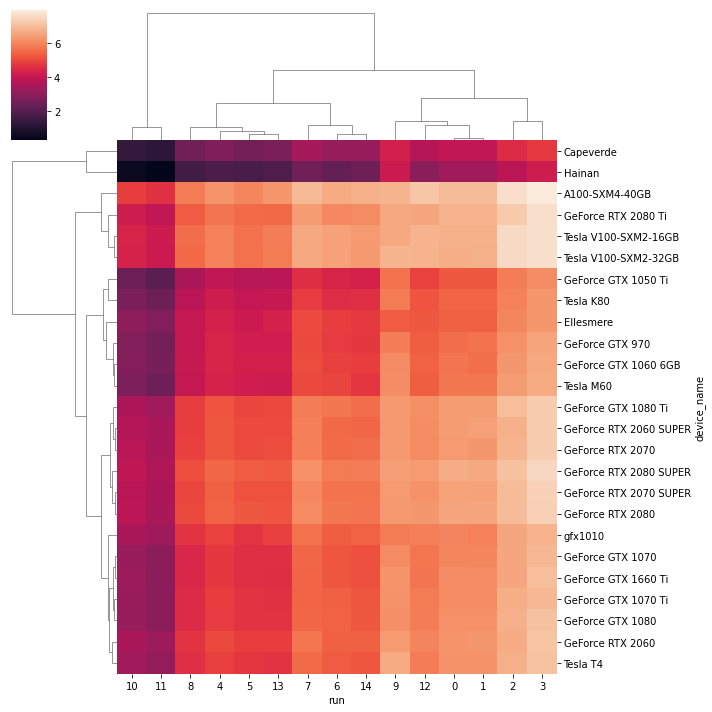

In [13]:
sns.clustermap(
    data
    .groupby(['run', 'device_name']).filter(lambda x: len(x) > 10)
    .groupby('device_name').filter(lambda x: len(x.groupby('run')) == 15)
    .groupby(['run', 'device_name'])
    ['perf_ns_per_day']
    .mean()
    .pipe(lambda x: np.log(x))
    .unstack('run'))